<a href="https://colab.research.google.com/github/Keshav-Sundar-4/Gray-Scott/blob/main/Gray_Scott_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!wget https://raw.githubusercontent.com/Keshav-Sundar-4/RD_ML_Model/main/Gray-Scott_Target3.png

--2024-10-02 18:39:27--  https://raw.githubusercontent.com/Keshav-Sundar-4/RD_ML_Model/main/Gray-Scott_Target3.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-10-02 18:39:27 ERROR 404: Not Found.



In [33]:
#@title Imports

%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from PIL import Image
from scipy.signal import convolve2d
import time
import os


In [34]:
#@title Seed State + helper functions

def seed_state(N, random_influence=0.2):
    """
    Initialize concentration grids U and V.

    Parameters:
    - N: Grid size (N x N)
    - random_influence: Amount of noise to add

    Returns:
    - U, V: Initialized concentration grids
    """
    U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
        random_influence * np.random.random((N, N)).astype(np.float32)
    V = random_influence * np.random.random((N, N)).astype(np.float32)

    # Add disturbance in the center
    N2 = N // 2
    r = int(N / 10.0)

    U[N2-r:N2+r, N2-r:N2+r] = 0.50
    V[N2-r:N2+r, N2-r:N2+r] = 0.25

    return U, V

def to_rgb(U, V):
    """
    Convert U and V concentration grids to an RGB image.

    Parameters:
    - U, V: Concentration grids

    Returns:
    - image: PIL Image in RGB format
    """
    U_np = U.numpy().squeeze()
    V_np = V.numpy().squeeze()

    # Normalize U and V to [0, 1]
    U_normalized = np.clip(U_np, 0, 1)
    V_normalized = np.clip(V_np, 0, 1)

    # Create RGB channels
    red_channel = (U_normalized * 255).astype(np.uint8)
    green_channel = (V_normalized * 255).astype(np.uint8)
    blue_channel = np.zeros_like(red_channel)

    # Stack channels to create RGB image
    rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)
    image = Image.fromarray(rgb_image, mode='RGB')
    return image

def load_target_image(file_path, size=256):
    """
    Load and preprocess the target image.

    Parameters:
    - file_path: Path to the target image file
    - size: Desired size to resize the image (size x size)

    Returns:
    - target_U, target_V: Target concentration grids
    """
    image = Image.open(file_path).convert('RGB')
    image = image.resize((size, size))
    image_np = np.array(image).astype(np.float32) / 255.0

    # Extract U and V from RGB channels
    target_U = image_np[..., 0]  # Red channel
    target_V = image_np[..., 1]  # Green channel

    # Expand dimensions to match simulation variables
    target_U = tf.expand_dims(tf.expand_dims(target_U, axis=0), axis=-1)  # Shape: [1, size, size, 1]
    target_V = tf.expand_dims(tf.expand_dims(target_V, axis=0), axis=-1)  # Shape: [1, size, size, 1]

    return target_U, target_V


In [35]:
#@title Paramter Creation

# Parameters
Du = 0.16       # Diffusion coefficient for U
Dv = 0.08       # Diffusion coefficient for V
F = 0.060       # Feed rate
k = 0.062       # Kill rate
dt = 1.0        # Time step size
size = 256      # Grid size (size x size)

# Laplacian kernel for convolution
laplacian_kernel = tf.constant([[0, 1, 0],
                                [1, -4, 1],
                                [0, 1, 0]], dtype=tf.float32)
laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])  # Shape: [filter_height, filter_width, in_channels, out_channels]

# Initialize U and V
U_init, V_init = seed_state(size)

# Convert to TensorFlow variables and add batch and channel dimensions
U = tf.Variable(tf.expand_dims(tf.expand_dims(U_init, axis=0), axis=-1))  # Shape: [1, size, size, 1]
V = tf.Variable(tf.expand_dims(tf.expand_dims(V_init, axis=0), axis=-1))  # Shape: [1, size, size, 1]




In [36]:
#@title Update Function

@tf.function
def gray_scott_update(U, V, Du, Dv, F, k, dt=1.0):
    """
    Perform one update step of the Gray-Scott model.

    Parameters:
    - U, V: Current concentration grids
    - Du, Dv: Diffusion coefficients
    - F, k: Feed and kill rates
    - dt: Time step size
    """
    # Compute Laplacian using convolution
    laplacian_U = tf.nn.conv2d(U, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')
    laplacian_V = tf.nn.conv2d(V, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')

    # Reaction terms
    UVV = U * V * V

    # Update equations
    dU = Du * laplacian_U - UVV + F * (1 - U)
    dV = Dv * laplacian_V + UVV - (F + k) * V

    # Update concentrations
    U.assign_add(dU * dt)
    V.assign_add(dV * dt)

    # Clip values to maintain stability
    U.assign(tf.clip_by_value(U, 0.0, 1.0))
    V.assign(tf.clip_by_value(V, 0.0, 1.0))

In [37]:
#@title Visualization
def visualize(U, V, step, interval=50):
    """
    Visualize the current state of the simulation.

    Parameters:
    - U, V: Current concentration grids
    - step: Current simulation step
    - interval: Time between frames in seconds
    """
    image = to_rgb(U, V)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Step {step}")
    plt.axis('off')
    plt.show()

    clear_output(wait=True)
    display(image)
    time.sleep(0.01)  # Adjust for desired speed

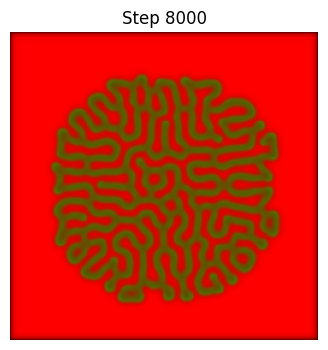

In [ ]:
#@title tf simulation

# Number of simulation steps
num_steps = 20000

# Visualization interval (steps between frames)
vis_interval = 500

# Initialize matplotlib figure
plt.figure(figsize=(4,4))

for step in range(1, num_steps + 1):
    gray_scott_update(U, V, Du, Dv, F, k, dt)

    if step % vis_interval == 0:
        # Visualize the current state
        image = to_rgb(U, V)
        plt.imshow(image)
        plt.title(f"Step {step}")
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(0.1)  # Pause to allow the image to render

In [ ]:
#@title Setup Training

# Initialize trainable parameters
Du = tf.Variable(0.16, dtype=tf.float32)
Dv = tf.Variable(0.08, dtype=tf.float32)
F = tf.Variable(0.060, dtype=tf.float32)
k = tf.Variable(0.062, dtype=tf.float32)

# Initialize optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(U_batch, V_batch, target_U_batch, target_V_batch, Du, Dv, F, k, optimizer):
    """
    Performs a single training step.

    Parameters:
    - U_batch, V_batch: Current concentration grids (TensorFlow tensors) with shape [batch_size, size, size, 1]
    - target_U_batch, target_V_batch: Target concentration grids (TensorFlow tensors) with shape [batch_size, size, size, 1]
    - Du, Dv, F, k: Trainable parameters (TensorFlow variables)
    - optimizer: TensorFlow optimizer

    Returns:
    - loss: Computed loss for the batch
    """
    with tf.GradientTape() as tape:
        # Perform simulation steps (e.g., 1 step per train_step)
        gray_scott_update(U_batch, V_batch, Du, Dv, F, k, dt=1.0)

        # Compute loss as Mean Squared Error between simulation and target
        loss_u = tf.reduce_mean(tf.square(U_batch - target_U_batch))
        loss_v = tf.reduce_mean(tf.square(V_batch - target_V_batch))
        loss = loss_u + loss_v

    # Compute gradients with respect to trainable parameters
    grads = tape.gradient(loss, [Du, Dv, F, k])

    # Normalize gradients to prevent exploding gradients
    grads = [g / (tf.norm(g) + 1e-8) for g in grads]

    # Apply gradients to update parameters
    optimizer.apply_gradients(zip(grads, [Du, Dv, F, k]))

    return loss

In [ ]:
#@title Training Loop

def train_simulation(target_image_path,
                    batch_size=4,
                    pool_size=16,
                    num_iterations=20000,
                    vis_interval=500,
                    seed_injection_interval=32,
                    save_interval=1000,
                    save_path='model_parameters'):
    """
    Trains the Gray-Scott simulation to match a target image.

    Parameters:
    - target_image_path: File path to the target image
    - batch_size: Number of simulations per training batch
    - pool_size: Total number of simulations in the pool
    - num_iterations: Number of training iterations
    - vis_interval: Steps between visualizations
    - seed_injection_interval: Steps between seed state injections
    - save_interval: Steps between saving model parameters
    - save_path: Directory path to save model parameters
    """
    # Load and process target image
    target_U, target_V = load_target_image(target_image_path, size=size)

    # Initialize a pool of simulations
    pool_U = []
    pool_V = []
    for _ in range(pool_size):
        U_init, V_init = seed_state(size)
        # Expand dimensions to [1, size, size, 1]
        U_tf = tf.Variable(tf.expand_dims(tf.expand_dims(U_init, axis=0), axis=-1))
        V_tf = tf.Variable(tf.expand_dims(tf.expand_dims(V_init, axis=0), axis=-1))
        pool_U.append(U_tf)
        pool_V.append(V_tf)

    pool_U = tf.stack(pool_U)  # Shape: [pool_size, 1, size, 1]
    pool_V = tf.stack(pool_V)  # Shape: [pool_size, 1, size, 1]

    # Initialize loss log
    loss_log = []

    # Create a pool index array
    pool_indices = np.arange(pool_size)

    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Training loop
    for iteration in range(1, num_iterations + 1):
        # Select a random batch from the pool
        batch_indices = np.random.choice(pool_size, batch_size, replace=False)
        U_batch = tf.gather(pool_U, batch_indices)  # Shape: [batch_size, 1, size, 1]
        V_batch = tf.gather(pool_V, batch_indices)  # Shape: [batch_size, 1, size, 1]

        # Occasionally inject seed states into the batch
        if iteration % seed_injection_interval == 0:
            for i in range(batch_size):
                U_new, V_new = seed_state(size)
                U_new = tf.expand_dims(tf.expand_dims(U_new, axis=0), axis=-1)
                V_new = tf.expand_dims(tf.expand_dims(V_new, axis=0), axis=-1)
                U_batch = tf.tensor_scatter_nd_update(U_batch, [[i, 0, 0, 0]], [U_new.numpy().flatten()])
                V_batch = tf.tensor_scatter_nd_update(V_batch, [[i, 0, 0, 0]], [V_new.numpy().flatten()])

        # Perform a training step
        loss = train_step(U_batch, V_batch, target_U, target_V, Du, Dv, F, k, optimizer)
        loss_log.append(loss.numpy())

        # Update the pool with the new state
        pool_U = tf.tensor_scatter_nd_update(pool_U,
                                            tf.expand_dims(batch_indices, axis=1),
                                            U_batch.numpy())
        pool_V = tf.tensor_scatter_nd_update(pool_V,
                                            tf.expand_dims(batch_indices, axis=1),
                                            V_batch.numpy())

        # Visualization and logging
        if iteration % vis_interval == 0:
            clear_output(wait=True)

            # Plot the loss graph
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(loss_log, '.', alpha=0.3)
            if np.min(loss_log) > 0.0:
                plt.yscale('log')
            plt.ylim(np.min(loss_log), loss_log[0])
            plt.title('Loss over Iterations')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.grid(True)

            # Display seed states and outputs
            seed_states_U = U_batch[:4]
            seed_states_V = V_batch[:4]
            outputs_U = pool_U[batch_indices[:4]]
            outputs_V = pool_V[batch_indices[:4]]

            fig, axes = plt.subplots(4, 2, figsize=(8, 16))
            for i in range(4):
                # Seed state
                image_seed = to_rgb(seed_states_U[i], seed_states_V[i])
                axes[i, 0].imshow(image_seed)
                axes[i, 0].set_title(f'Seed State {i+1}')
                axes[i, 0].axis('off')

                # Output state
                image_output = to_rgb(outputs_U[i], outputs_V[i])
                axes[i, 1].imshow(image_output)
                axes[i, 1].set_title(f'Output State {i+1}')
                axes[i, 1].axis('off')

            plt.tight_layout()
            plt.show()

            print(f"Iteration {iteration}, Loss: {loss.numpy()}")

        # Save model parameters periodically
        if iteration % save_interval == 0:
            params = {
                'Du': Du.numpy(),
                'Dv': Dv.numpy(),
                'F': F.numpy(),
                'k': k.numpy()
            }
            np.save(os.path.join(save_path, f'parameters_{iteration}.npy'), params)
            print(f"Saved parameters at iteration {iteration}")

    # Plot final loss graph
    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(loss_log, '.', alpha=0.3)
    if np.min(loss_log) > 0.0:
        plt.yscale('log')
    plt.ylim(np.min(loss_log), np.max(loss_log))
    plt.title('Final Loss over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Display final outputs
    for i in range(4):
        image_output = to_rgb(pool_U[i], pool_V[i])
        display(image_output)

    print("Training completed.")


In [ ]:
#@title Model Training

target_image_path = 'Gray-Scott_Target'  # Replace with your image path
train_simulation(target_image_path=target_image_path,
                batch_size=4,
                pool_size=16,
                num_iterations=20000,
                vis_interval=500,
                seed_injection_interval=32,
                save_interval=1000,
                save_path='trained_parameters')

# To load saved parameters
saved_params = np.load('trained_parameters/parameters_1000.npy', allow_pickle=True).item()
Du.assign(saved_params['Du'])
Dv.assign(saved_params['Dv'])
F.assign(saved_params['F'])
k.assign(saved_params['k'])
